In [66]:
library(tidyverse)
library(cowplot)
library(RColorBrewer)

# Custom package
library(rutils)

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
projects <- c("CESC", "UCS", "UCEC")

In [3]:
text_size <- 8
label_text_size <- 10
small_text_size <- 8
guide_size <- 4
family <- "ArialMT"
dpi <- 320
fig1_ht <- 5
fig1_wd <- 6

In [8]:
dset_idx <- 1

In [33]:
expr_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")) %>%
    filter(geneID == "MUC4") %>%
    rutils::transpose_df("geneID", "sample_name")
coldata_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/coldata.tsv")) %>%
    select(-data_source)
survival_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")) %>%
    decode_figo_stage(to = "c") %>%
    mutate(figo_stage = str_replace(figo_stage, "figo_stage_", "Stage ")) %>%
    select(sample_name, figo_stage)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full column specifications.



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  condition = col_character(),
  data_source = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)




In [92]:
joined_df <- expr_df %>%
    inner_join(coldata_df, by = "sample_name") %>%
    left_join(survival_df, by = "sample_name") %>%
    mutate(condition = str_to_title(condition)) %>%
    mutate(condition = factor(condition), figo_stage = factor(figo_stage)) %>%
    filter(!(condition == "Tumor" & is.na(figo_stage)))

# By FIGO stage

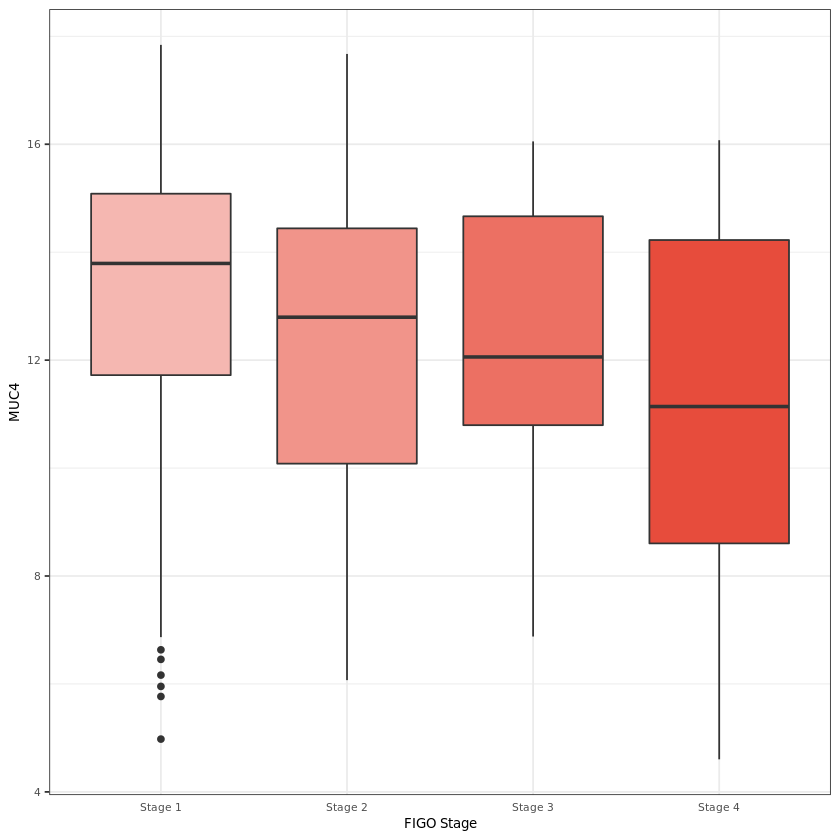

In [93]:
figo_color_scale <- c("Stage 1" = "#F5B7B1", "Stage 2" = "#F1948A", "Stage 3" = "#EC7063", "Stage 4" = "#E74C3C")
ggplot(data = joined_df %>% filter(condition == "Tumor")) +
    geom_boxplot(aes(figo_stage, MUC4, fill = figo_stage)) +
#     scale_fill_brewer(palette = "Set2") +
    scale_fill_manual(name = NULL, values = figo_color_scale) +
    theme_bw() +
    theme(
            text = element_text(size = text_size, family = family),
            axis.ticks.x = element_blank(),
            legend.position = "none"
#             axis.text.x = element_text(angle = 90, vjust = 0.9, hjust = 0.9),
#             axis.title.x = element_blank()
    ) +
    labs(x = "FIGO Stage", y = "MUC4")
ggsave(paste0(dirs$figures_dir, "/one_off/", unified_dsets[dset_idx], "_MUC4_by_FIGO.png"), dpi = dpi, height = 3, width = 3)

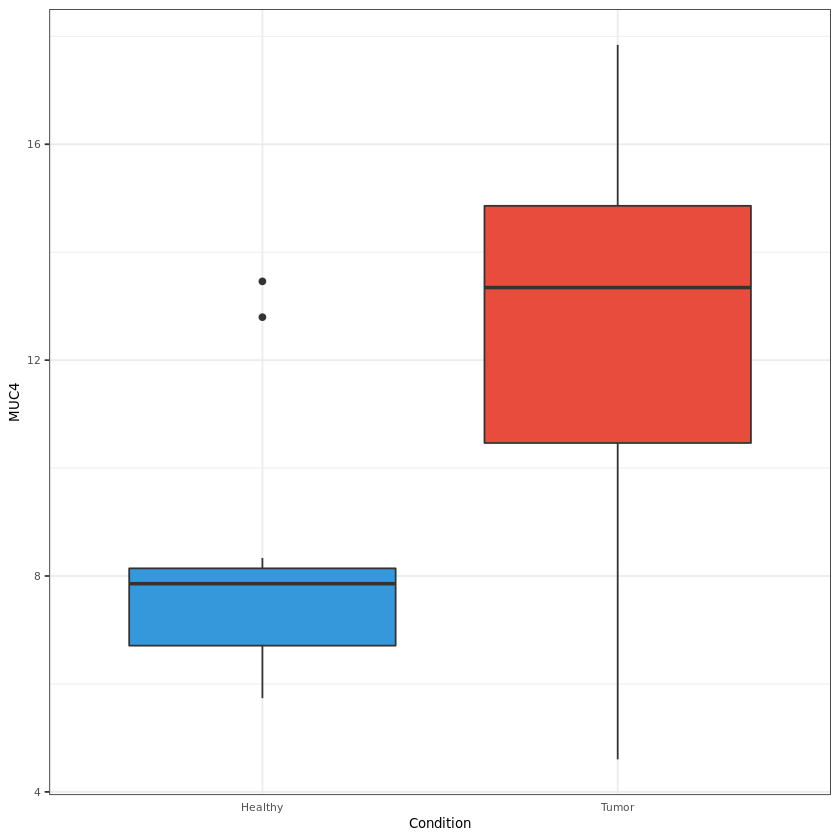

In [97]:
condition_color_scale <- c("Healthy" = "#3498DB", "Tumor" = "#E74C3C")
ggplot(data = joined_df) +
    geom_boxplot(aes(condition, MUC4, fill = condition)) +
    scale_fill_manual(name = NULL, values = condition_color_scale) +
    theme_bw() +
    theme(
            text = element_text(size = text_size, family = family),
            axis.ticks.x = element_blank(),
            legend.position = "none"
    ) +
    labs(x = "Condition", y = "MUC4")

ggsave(paste0(dirs$figures_dir, "/one_off/", unified_dsets[dset_idx], "_MUC4_by_condition.png"), dpi = dpi, height = 3, width = 3)

# Write out special .tsv

In [100]:
joined_df %>% write_tsv(paste0(dirs$analysis_dir, "/one_off/cesc_muc4.tsv"))

In [99]:
joined_df %>%
    group_by(figo_stage) %>%
    count()

figo_stage,n
<fct>,<int>
Stage 1,135
Stage 2,61
Stage 3,40
Stage 4,19
NA,13
